In [1]:
from deepsvdd.src.base.torchvision_dataset import TorchvisionDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset, ConcatDataset
from PIL import Image
from dataclasses import dataclass, field
from pathlib import Path
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
from deepsvdd.src.deepSVDD import DeepSVDD
from typing import List
import torch.nn as nn
import math
import dacite
import json

from deepsvdd.src.datasets.preprocessing import get_target_label_idx

c:\Users\soapun\.virtualenvs\svdd_new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class GrowVisionDatasetConfig:
    path : Path
    batch_size : int = 32
    img_size : int = 32
    window_len : int = 1
    stride : int = 1
    limit : int = None
    pattern : str = "*.jpg"

In [3]:
@dataclass
class MainConfig:
    save_path : Path

    train_configs : List[GrowVisionDatasetConfig]
    test_configs : List[GrowVisionDatasetConfig] = None


In [4]:
with open("settings\\green_red.json", encoding="utf-8") as f:
    config_dict = json.load(f)
config = dacite.from_dict(data=config_dict, data_class=MainConfig, config=dacite.Config(type_hooks={Path : Path}))

In [5]:
class GrowVisionDataset(Dataset):
    
    def __init__(self, config : GrowVisionDatasetConfig = None):
        if config is None:
            return

        files = list(reversed(sorted(config.path.glob(config.pattern))))

        target_path = config.path / "target.csv"
        if target_path.is_file():
            df = pd.read_csv(config.path / "target.csv", engine="python")
            files = [config.path / f for f in df.filename]
            df.set_index("filename", inplace=True)
        else:
            df = pd.DataFrame(columns=["filename", "target"])
            df['files'] = [f.name for f in files]
            df['target'] = 0

        self.labels = []
        self.data = []
        for f in files:
            if f.is_file():
                img = Image.open(f).resize((config.img_size, config.img_size))
                img = np.array(img) / 255.
                self.data.append(img)

                self.labels.append(df.loc[f.name].target)

        self.data = self.data[:config.limit]


        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

        if config.window_len > 1:
            imgs = []
            new_labels = []
            for i in range(0, len(self.data) - config.window_len*config.stride):
                imgs.append(self.data[i:i +config.window_len*config.stride:config.stride])
                new_labels.append(int(bool(self.labels[i:i+config.window_len*config.stride:config.stride].sum())))

            self.labels = np.array(new_labels)
            self.data = np.array(imgs)
        self.data = np.moveaxis(self.data, -1, 1)

   
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).float(), self.labels[idx], idx
    
    def __add__(self, obj):
        new_obj = GrowVisionDataset()
        new_obj.data = np.concatenate([self.data, obj.data], axis=0)
        new_obj.labels = np.concatenate([self.labels, obj.labels], axis=0)
        return new_obj

In [6]:
class SVDDGrowVisionDataset(TorchvisionDataset):

    def __init__(self, root: str, config : GrowVisionDatasetConfig, normal_class=0):
        super().__init__(root)

        self.n_classes = 2
        self.normal_classes = [normal_class]
        self.outlier_classes = [1]

        train_set = GrowVisionDataset(config)
        
        train_idx_normal = get_target_label_idx(train_set.labels, self.normal_classes)
        
        self.train_set = Subset(train_set, train_idx_normal)
        self.test_set = GrowVisionDataset(config)


In [7]:
class SVDDGrowVisionComposeDataset(TorchvisionDataset):

    def __init__(self, root: str, configs : List[GrowVisionDatasetConfig], normal_class=0):
        super().__init__(root)

        self.n_classes = 2
        self.normal_classes = [normal_class]
        self.outlier_classes = [1]

        train_sets = [
            GrowVisionDataset(c)
            for c in configs
        ]
        train_set = sum(train_sets[1:], train_sets[0])
        train_idx_normal = get_target_label_idx(train_set.labels, self.normal_classes)
        
        self.train_set = Subset(train_set, train_idx_normal)
        self.test_set = train_set

In [17]:
dataset = SVDDGrowVisionComposeDataset(root=config.train_configs[0].path, configs=config.train_configs)
deep_SVDD = DeepSVDD("one-class", 0.1)
deep_SVDD.set_network("cifar10_LeNet_3d")

In [18]:
deep_SVDD.train(dataset,
    optimizer_name="adam",
    lr=0.1,
    n_epochs=60,
    lr_milestones=[],
    batch_size=300,
    weight_decay=0.001,
    device="cuda",
)

  0%|          | 0/60 [00:00<?, ?it/s]c:\Users\soapun\.virtualenvs\svdd_new\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 60/60 [14:17<00:00, 14.29s/it]


In [19]:
deep_SVDD.test(dataset, device="cuda")
print(deep_SVDD.results['test_auc'])

0.5226571507445478


In [20]:
if config.test_configs is not None and config.test_configs:
    test_dataset = SVDDGrowVisionComposeDataset(root=config.test_configs[0].path, configs=config.test_configs)
    deep_SVDD.test(test_dataset, device="cuda")
    print(deep_SVDD.results['test_auc'])

0.6139506631518734


In [12]:
df = pd.DataFrame(deep_SVDD.results['test_scores'], columns=["idx", "target", "score"])

In [13]:
from grow_datasets import plot_item

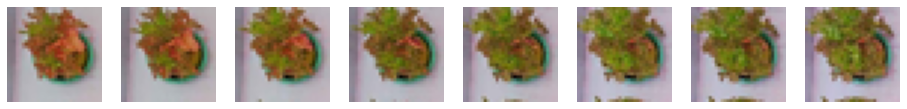

In [14]:
plot_item(torch.movedim(test_dataset.test_set[650][0], 0, -1))


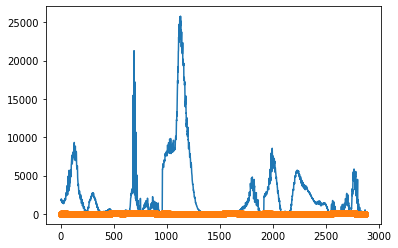

In [15]:
plt.plot([i[2] for i in deep_SVDD.results['test_scores']])
plt.plot([i[1]*100 for i in deep_SVDD.results['test_scores']], 'o')